In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsolutePercentageError

# Data Understanding

In [2]:
airline_df = pd.read_csv('data/airlines.csv')
country_df = pd.read_csv('data/country.csv')
covid_df = pd.read_csv('data/covid.csv')
gdp_df = pd.read_csv('data/gdp.csv')
load_factors_df = pd.read_csv('data/load_factor_data.csv')
seats_df = pd.read_csv('data/seats.csv')
validation_df = pd.read_csv('data/validation.csv')
submission_df = pd.read_csv('data/submission.csv')

## Airline and Country Datasets/Look-Up Tables

In [3]:
airline_df

,airline_code_iata,airline_type
0,TZ,Low-cost
1,VH,Low-cost
2,NS,Regional
3,6D,Leisure
4,TV,Mainline
...,...,...
278,J2,Low-cost
279,VY,Low-cost
280,ZB,Mainline
281,PQ,Low-cost


In [4]:
country_df

,country,iata,iso,numeric
0,Afghanistan,AF,AFG,4
1,Åland Islands,AX,ALA,248
2,Albania,AL,ALB,8
3,Algeria,DZ,DZA,12
4,American Samoa,AS,ASM,16
...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876
245,Western Sahara,EH,ESH,732
246,Yemen,YE,YEM,887
247,Zambia,ZM,ZMB,894


### Notes
- Airlines and Country datasets are basically lookup tables that should be used to map codes in the other dataset to understandable info
- Some airline codes in the airlines dataset have multiple airline types for each airline_code - should make an embedding that encapsulates this with a vector representation
    - There are 6 airline types, so initial represent each airline_code with a corresponding airline_type from $n=[0-5]$
    - Create a numeric representation that takes multiple types for each code into account: achieved by taking the sum of $2^n$ for each airline type for an airline code
    $$
        \qquad\text{embedding}_{\text{airline_code}}=\sum_{\text{type}\in\text{airline_code}}2^{\text{type}}
    $$
    - Produce a final 6-bit binary representation of $\text{embedding}_{\text{airline_code}}$
        - Gives a sparse matrix that is learnable by a time-series model

## COVID Dataset

In [5]:
covid_df

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,stringency_index,reproduction_rate,total_tests,new_tests,positive_rate,total_vaccinations,population,population_density
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,8.33,NaN,NaN,NaN,NaN,NaN,41128772.0,54.422
1,AFG,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,8.33,NaN,NaN,NaN,NaN,NaN,41128772.0,54.422
2,AFG,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,8.33,NaN,NaN,NaN,NaN,NaN,41128772.0,54.422
3,AFG,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,8.33,NaN,NaN,NaN,NaN,NaN,41128772.0,54.422
4,AFG,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,8.33,NaN,NaN,NaN,NaN,NaN,41128772.0,54.422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158012,ZWE,Zimbabwe,2021-12-27,205449.0,1098.0,4908.0,17.0,47.22,0.85,1678579.0,3416.0,0.3116,7222381.0,16320539.0,42.729
158013,ZWE,Zimbabwe,2021-12-28,207548.0,2099.0,4940.0,32.0,47.22,0.83,1686251.0,7672.0,0.3388,7226334.0,16320539.0,42.729
158014,ZWE,Zimbabwe,2021-12-29,207548.0,0.0,4940.0,0.0,47.22,0.82,1693985.0,7734.0,0.2550,7238939.0,16320539.0,42.729
158015,ZWE,Zimbabwe,2021-12-30,211728.0,4180.0,4997.0,57.0,47.22,0.82,1701080.0,7095.0,0.2957,NaN,16320539.0,42.729


### Notes
- Stringency index is a measure based on 9 response indicators, one of which being travel bans, on a scale from 0 to 100 => very useful feature

- Definite features to include
    - iso_code
    - location
    - date
    - new_cases
    - stringency_index (normalised)
- Potential features to include 
    - reproduction_rate - represents transmission of COVID 2-3 weeks ago (increased uncertainty in value due to changes in testing policy)
    - population density - could be used to identify areas where the spread of COVID is greater, leading to more airline disruptions

## GDP Dataset

In [6]:
gdp_df

,location_iso,indicator,subject,measure,frequency,time,value
0,OECD,QGDP,TOT,PC_CHGPP,A,2017,2.638162
1,OECD,QGDP,TOT,PC_CHGPP,A,2018,2.386861
2,OECD,QGDP,TOT,PC_CHGPP,A,2019,1.698699
3,OECD,QGDP,TOT,PC_CHGPP,A,2020,-4.352352
4,OECD,QGDP,TOT,PC_CHGPP,A,2021,5.676700
...,...,...,...,...,...,...,...
2900,HRV,QGDP,TOT,PC_CHGPY,Q,2021-Q3,16.868433
2901,HRV,QGDP,TOT,PC_CHGPY,Q,2021-Q4,12.336496
2902,HRV,QGDP,TOT,PC_CHGPY,Q,2022-Q1,7.568017
2903,HRV,QGDP,TOT,PC_CHGPY,Q,2022-Q2,8.458661


### Notes
- All GDP data is on a quarterly basis
- There are two measures: 
    1. Percent change over prior period
    2. Percent change over prior year
- Should adjust the value to all be either the percent change over the prior period or year
- Just dont use the dataset


## Load Factors Dataset

In [7]:
load_factors_df

,organization_code_iata,organization_code_icao,period_start_date,period_end_date,accounting_period,passenger_load_factor_pct
0,EI,EIN,2020-07-01,2020-07-31,Month 7,24.696155
1,EI,EIN,2020-08-01,2020-08-31,Month 8,29.712449
2,EI,EIN,2020-09-01,2020-09-30,Month 9,25.965699
3,EI,EIN,2020-10-01,2020-10-31,Month 10,17.795881
4,EI,EIN,2020-11-01,2020-11-30,Month 11,15.954516
...,...,...,...,...,...,...
10263,I8,IZA,2021-10-01,2021-10-31,Month 10,72.100000
10264,WZ,RWZ,2021-10-01,2021-10-31,Month 10,80.900000
10265,FV,SDM,2021-10-01,2021-10-31,Month 10,84.600000
10266,7R,RLU,2021-10-01,2021-10-31,Month 10,73.400000


### Notes
- There are random periods with 0 data for some reason
- Different accounting periods are used Monthly, Annual, Quarterly
- There are 704 annual datapoints, 61 quarterly datapoints and 708 data points with a 0 for the % load factor, we can just throw them away
    - **Test the airline_type for these 0 % load factors**
- icao column has NaNs that may need to be discarded
- It might be reasonable to leave the zeroes in post-covid?

## Seats Dataset

In [8]:
seats_df

,operating_airline,departure_country_iata,arrival_country_iata,seats_year,seats_month,total_seats
0,8E,US,US,2017,10,3130
1,AA,US,US,2021,12,17677677
2,BB,VI,VI,2020,3,2295
3,NH,JP,JP,2020,8,3146684
4,NX,CN,MO,2022,2,58849
...,...,...,...,...,...,...
604824,QR,ZA,KE,2020,10,0
604825,EY,ZA,KE,2021,6,0
604826,OU,DK,HR,2020,3,1600
604827,KQ,MZ,KE,2021,6,672


### Notes
- This is the primary dataset that links everything together
- The operating_airline IATA code can be used with the `airline` dataset to get the airline_type for the flights 
- The departure_country_iata can be used with the `country` dataset to get the iso code, and then used with the COVID dataset (and GDP if we use the GDP data)
    - If the country being departed from has high COVID rate, maybe the outbound flights are restricted
- The arrival_country_iata can be used with the `country` dataset to get the iso code, and then used with the COVID dataset (and GDP if we use the GDP data)
    - If the country being departed from has high COVID rate, maybe the incoming flights are affected
- seats_year and seats_month used to identify when the flight was 
- total_seats tells us the number of booked seats for the flights
    - Use this with the `load factors` dataset
    
## Validation Dataset

In [9]:
validation_df

,time,load_year,load_month,organization_code_icao,organization_code_iata,passenger_load_factor_pct
0,2022-01-01,2022,1,AKT,5T,58.690042
1,2022-02-01,2022,2,AKT,5T,63.308469
2,2022-03-01,2022,3,AKT,5T,64.637411
3,2022-04-01,2022,4,AKT,5T,66.932459
4,2022-05-01,2022,5,AKT,5T,67.446506
...,...,...,...,...,...,...
115,2022-08-01,2022,8,WZZ,W6,90.500000
116,2022-09-01,2022,9,WZZ,W6,87.100000
117,2022-10-01,2022,10,WZZ,W6,87.800000
118,2022-11-01,2022,11,WZZ,W6,88.100000


### Notes 
- organization_code_iata/icao can be used to get the airline_type from the `airline` dataset
- Predict passenger_load_factor_pct from temporal info, organization code, and airline_type

## Submission Dataset

In [10]:
submission_df

,load_year,load_month,organization_code_iata,forecast_load_factor_pct
0,2022,1,G4,NaN
1,2022,2,G4,NaN
2,2022,3,G4,NaN
3,2022,4,G4,NaN
4,2022,5,G4,NaN
...,...,...,...,...
595,2022,8,Y8,NaN
596,2022,9,Y8,NaN
597,2022,10,Y8,NaN
598,2022,11,Y8,NaN


# Feature Selection
We chose to use the following features:
- month `int`
- year `int`
- organization_code `index(IATA)->int`
- airline_type `embed(airline)->vec or int`
- $\sum_{\text{airline}}\text{total seats}$ `norm(int)`
- Stringency index `norm(int)`

# Data Preparation
## Airline Dataset Preparation

In [11]:
airline_df = airline_df.sort_values('airline_code_iata')
airline_df

,airline_code_iata,airline_type
46,2I,Regional
269,2I,Cargo
127,2L,Cargo
60,2L,Airline ACMI
265,3E,Regional
...,...,...
64,YX,Regional
280,ZB,Mainline
144,ZH,Mainline
71,ZL,Regional


In [12]:
airline_df

,airline_code_iata,airline_type
46,2I,Regional
269,2I,Cargo
127,2L,Cargo
60,2L,Airline ACMI
265,3E,Regional
...,...,...
64,YX,Regional
280,ZB,Mainline
144,ZH,Mainline
71,ZL,Regional


In [13]:
# create embedding for airline types
airline_type_map = {'Low-cost': 1, 'Regional': 2, 'Mainline': 3, 'Leisure': 4, 'Cargo': 5, 'Airline ACMI': 6}
airline_df['airline_type'] = airline_df['airline_type'].map(airline_type_map)

In [14]:
airline_df['airline_type'] = 2 ** airline_df['airline_type']
airline_df = airline_df.groupby('airline_code_iata', as_index=False).agg({'airline_type': 'sum'})
airline_df.reset_index()
airline_df

,airline_code_iata,airline_type
0,2I,36
1,2L,96
2,3E,4
3,3M,4
4,3U,8
...,...,...
251,YX,4
252,ZB,8
253,ZH,8
254,ZL,4


## COVID Dataset Preparation

We want the following features from the `covid` dataset:

    - iso_code
    - location
    - date
    - new_cases
    - stringency_index (normalised)
- Potential features to include 
    - reproduction_rate - represents transmission of COVID 2-3 weeks ago (increased uncertainty in value due to changes in testing policy)
    - population density - could be used to identify areas where the spread of COVID is greater, leading to more airline disruptions

In [15]:
# get subset of dataframe and remove nan rows
covid_df = covid_df[["iso_code", "location", "date", "new_cases", "stringency_index"]]
covid_df = covid_df.dropna()
covid_df.reset_index()
covid_df

,iso_code,location,date,new_cases,stringency_index
0,AFG,Afghanistan,2020-02-24,5.0,8.33
1,AFG,Afghanistan,2020-02-25,0.0,8.33
2,AFG,Afghanistan,2020-02-26,0.0,8.33
3,AFG,Afghanistan,2020-02-27,0.0,8.33
4,AFG,Afghanistan,2020-02-28,0.0,8.33
...,...,...,...,...,...
158012,ZWE,Zimbabwe,2021-12-27,1098.0,47.22
158013,ZWE,Zimbabwe,2021-12-28,2099.0,47.22
158014,ZWE,Zimbabwe,2021-12-29,0.0,47.22
158015,ZWE,Zimbabwe,2021-12-30,4180.0,47.22


In [16]:
airline_df.to_csv('airline_df.csv', index=False)

## Training Dataset

In [17]:
train_df = pd.read_csv('filtered_data/final_df.csv')
train_df

,Unnamed: 0,index,organization_code_iata,year,month,passenger_load_factor_pct,total_seats,sin_month,cos_month,airline_type_0,airline_type_1,airline_type_2,airline_type_3,airline_type_4,airline_type_5,stringency_index
0,0,0,EI,2020,7,-1.759903,-0.443512,1.224647e-16,-1.000000,0,0,1,0,0,0,0.468976
1,1,1,AV,2020,7,-0.276395,-0.518508,1.224647e-16,-1.000000,0,0,1,0,0,0,0.468976
2,2,2,G4,2020,7,-0.657442,0.049565,1.224647e-16,-1.000000,0,0,0,0,1,0,0.468976
3,3,3,VW,2020,7,-1.492714,-0.508280,1.224647e-16,-1.000000,0,0,0,1,0,0,0.468976
4,4,4,AM,2020,7,-0.798619,-0.263266,1.224647e-16,-1.000000,0,0,1,0,0,0,0.468976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8144,8144,8144,UJ,2019,12,-2.788415,-0.523965,-5.000000e-01,0.866025,1,0,1,0,0,0,0.000000
8145,8145,8145,UT,2019,12,0.422541,-0.336211,-5.000000e-01,0.866025,0,0,1,0,0,0,0.000000
8146,8146,8146,PN,2019,12,0.985604,-0.267934,-5.000000e-01,0.866025,0,0,0,0,1,0,0.000000
8147,8147,8147,7W,2019,12,1.116595,-0.521628,-5.000000e-01,0.866025,0,1,0,0,0,0,0.000000


In [18]:
# set the index to be this and don't drop
train_df.set_index(keys=['organization_code_iata'], drop=False,inplace=True)
# get a list of names
names = train_df['organization_code_iata'].unique().tolist()
train_df = [train_df.loc[train_df.organization_code_iata==name].sort_values(['year', 'month'], ascending=[True, True]) for name in names]

In [19]:
# puts data in temporal order and sort by organization #
x_train = [train[["year", "month", "airline_type_0", "airline_type_1", "airline_type_2", "airline_type_3", "airline_type_4", "airline_type_5", "total_seats", "stringency_index"]].reset_index() for train in train_df]
y_train = [train[["passenger_load_factor_pct"]].reset_index() for train in train_df]

The dimension of the input data should be $(L\times N\times H_{in})$. The dimension of the input data becomes $(L\times N\times H_{out})$
- $L=8$ - sequence length
- $N=256$ - batch size
- $H_{in}=7$ - input size/number features
- $H_{out}=1$ - output size/number predicted steps

In [22]:
L = 8
N = 128
H_in = 8
H_out = 1

In [23]:
def make_tensor(x_data, y_data):
    # Create (N x L x H_in) data from (num_orgs x num_months x H_in)
    x_tensor = np.empty([0, L, H_in])
    y_tensor = np.empty([0, H_out])

    position = 0
    ORG = []
    YEAR = []
    MONTH = []
    # loop over every airline org
    for idx, (x, y) in enumerate(zip(x_data, y_data)):
        x = x.to_numpy()
        y = y.to_numpy()            
        x = x[:, 3:]
        y = y[:, 1:]
        
        for idx, (xs, ys) in enumerate(zip(x, y)):
            if idx > x.shape[0] - L-1:
                continue
                
            x_tensor = np.concatenate([x_tensor, x[idx:idx+L].reshape(1, L, -1)], axis=0)
            y_tensor = np.concatenate([y_tensor, y[idx+L].reshape(1, -1)], axis=0)
    
    x_tensor = torch.from_numpy(x_tensor.astype(float))
    y_tensor = torch.from_numpy(y_tensor.astype(float))
    
    return x_tensor, y_tensor

x_tensor, y_tensor = make_tensor(x_train, y_train)

In [24]:
x_tensor.shape

torch.Size([6505, 8, 8])

In [25]:
class MakeDataset(Dataset):
    def __init__(self, x_data, y_data):
        super().__init__()
        self.x = x_data
        self.y = y_data
    
    def __len__(self):
        return self.x.shape[0]
        
    def __getitem__(self, idx):
        x = self.x[idx].type('torch.DoubleTensor')
        y = self.y[idx].type('torch.DoubleTensor')
        return x, y

In [26]:
train_data = MakeDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_data, batch_size=N, shuffle=False)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 8, 8]), torch.Size([128, 1]))

# Time-Series Model

In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, unnorm_data):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, dropout=0.8, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
        unnorm_data = unnorm_data
        self.unnorm_data_std = unnorm_data['passenger_load_factor_pct'].std()
        self.unnorm_data_mean = unnorm_data['passenger_load_factor_pct'].mean()
    
    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        output = self.linear(output)
        return output
    
    def unnorm(self, pred):
        return pred * self.unnorm_data_std + self.unnorm_data_mean

In [28]:
unnorm_data = pd.read_csv('unnorm_final_df.csv')
model = LSTM(input_size=H_in, hidden_size=50, output_size=H_out, unnorm_data=unnorm_data).float().cuda() # input size=number of features, output size=number of timesteps to predict 
criterion = nn.MSELoss()
print(f"Total Seats:\n\tSTD = {unnorm_data['total_seats'].std()}\tMean = {unnorm_data['total_seats'].mean()}")
print(f"Load Factor %:\n\tSTD = {model.unnorm_data_std}\tMean = {model.unnorm_data_mean}\n")

Total Seats:
	STD = 3119831.3577753482	Mean = 1637131.555896429
Load Factor %:
	STD = 24.011541691769423	Mean = 66.95413646801686



In [29]:
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 100
for epoch in range(epochs+1):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        y_hat = model(x.float().cuda())
        loss = criterion(y_hat.float().cuda(), y.float().cuda())
        
        loss.backward()
        optimizer.step()   
        
    model.eval()
    if epoch % 5 == 0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.4f}')
        #torch.save(model.state_dict(), f'stringency_models/lstm-{epoch}.pt')

epoch:    0 loss:    1.0243
epoch:    5 loss:    1.2745
epoch:   10 loss:    1.4493
epoch:   15 loss:    1.3999
epoch:   20 loss:    1.2647
epoch:   25 loss:    1.1303


KeyboardInterrupt: 

# Model Validation

Required features:
- `organization_code_iata`
- `year`
- `month`
- `total_seats`
- `airline_type_0`
- `airline_type_1`
- `airline_type_2`
- `airline_type_3`
- `airline_type_4`
- `airline_type_5`
- `stringency_index`

The features must be sorted temporally and by organization (simplifying the timeseries), with the preceding $L$ months of data used to predict timestep $t+1$: i.e. to predict `passenger_load_factor_pct` at timestep $t+1$, we need the features above for each of the following timesteps $t-L : t$.

In [30]:
val_df = pd.read_csv('filtered_data/norm_validation_df.csv')
val_df

,Unnamed: 0,index,year,month,airline_type_0,airline_type_1,airline_type_2,airline_type_3,airline_type_4,airline_type_5,total_seats,passenger_load_factor_pct,organization_code_iata,stringency_index
0,0,0,2021.0,5.0,0,0,0,1,0,0,-0.682003,NaN,5T,0.255429
1,1,1,2021.0,5.0,0,0,0,1,0,0,-0.697524,NaN,EN,0.255429
2,2,2,2021.0,5.0,0,0,0,1,0,0,-0.712342,NaN,T3,0.255429
3,3,3,2021.0,5.0,0,0,0,1,0,0,-0.697881,NaN,I8,0.255429
4,4,4,2021.0,5.0,0,0,0,0,1,0,1.755714,NaN,NK,0.255429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,2022.0,12.0,0,0,1,0,0,0,0.118490,0.431197,S7,-0.299603
196,196,196,2022.0,12.0,0,0,0,0,1,0,-0.239904,0.551138,PQ,-0.299603
197,197,197,2022.0,12.0,0,0,1,0,0,0,-0.655302,-0.609631,R3,-0.299603
198,198,198,2022.0,12.0,0,0,1,0,0,0,-0.670629,0.394719,JJ,-0.299603


In [31]:
# set the index to be this and don't drop
val_df.set_index(keys=['organization_code_iata'], drop=False,inplace=True)
# get a list of names
names = val_df['organization_code_iata'].unique().tolist()
val_df = [val_df.loc[val_df.organization_code_iata==name].sort_values(['year', 'month'], ascending=[True, True]) for name in names]

In [32]:
# puts data in temporal order and sort by organization #
x_val = [val[["year", "month", "airline_type_0", "airline_type_1", "airline_type_2", "airline_type_3", "airline_type_4", "airline_type_5", "total_seats", "stringency_index"]].reset_index() for val in val_df]
y_val = [val[["passenger_load_factor_pct"]].reset_index() for val in val_df]

In [35]:
x_tensor, y_tensor = make_tensor(x_val, y_val)
print(x_tensor.shape)
val_data = MakeDataset(x_tensor, y_tensor)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)
x, y = next(iter(train_loader))
x.shape, y.shape

torch.Size([120, 8, 8])


(torch.Size([128, 8, 8]), torch.Size([128, 1]))

### Validate the Model

In [36]:
validation_unnorm = pd.read_csv('data/validation.csv')
val_mean = validation_unnorm['passenger_load_factor_pct'].mean()
val_std = validation_unnorm['passenger_load_factor_pct'].std()
unnorm_val = lambda x : x * val_std + val_mean
print(f"Mean: {val_mean}\tStd: {val_std}")
val_df = pd.read_csv('filtered_data/norm_validation_df.csv')
val_df

Mean: 73.75254314592475	Std: 9.994542354131912


,Unnamed: 0,index,year,month,airline_type_0,airline_type_1,airline_type_2,airline_type_3,airline_type_4,airline_type_5,total_seats,passenger_load_factor_pct,organization_code_iata,stringency_index
0,0,0,2021.0,5.0,0,0,0,1,0,0,-0.682003,NaN,5T,0.255429
1,1,1,2021.0,5.0,0,0,0,1,0,0,-0.697524,NaN,EN,0.255429
2,2,2,2021.0,5.0,0,0,0,1,0,0,-0.712342,NaN,T3,0.255429
3,3,3,2021.0,5.0,0,0,0,1,0,0,-0.697881,NaN,I8,0.255429
4,4,4,2021.0,5.0,0,0,0,0,1,0,1.755714,NaN,NK,0.255429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,2022.0,12.0,0,0,1,0,0,0,0.118490,0.431197,S7,-0.299603
196,196,196,2022.0,12.0,0,0,0,0,1,0,-0.239904,0.551138,PQ,-0.299603
197,197,197,2022.0,12.0,0,0,1,0,0,0,-0.655302,-0.609631,R3,-0.299603
198,198,198,2022.0,12.0,0,0,1,0,0,0,-0.670629,0.394719,JJ,-0.299603


In [37]:
torch.set_printoptions(sci_mode=False)
MAE = nn.L1Loss()
MAPE = MeanAbsolutePercentageError()

best_MAPE_model = {'epoch': 0, 'MAPE': 1, 'MAE': 100}

with torch.no_grad():
    for m in range(0, 20, 1):
        n = 0 
        mae = 0
        mape = 0
        model = LSTM(input_size=H_in, hidden_size=50, output_size=H_out, unnorm_data=unnorm_data).cpu() 
        model.load_state_dict(torch.load(f'stringency_models/lstm-{m}.pt'))
        for idx, (x, y) in enumerate(val_loader):
            y_hat = model(x.float())

            y = unnorm_val(y)[:, 0]
            y_hat = model.unnorm(y_hat)[:, 0]
            
            mape += MAPE(y, y_hat)
            mae += MAE(y, y_hat)
            n += 1
        
        # find best model
        if mape / n < best_MAPE_model['MAPE']:
            best_MAPE_model['epoch'] = m
            best_MAPE_model['MAPE'] = mape / n
            best_MAPE_model['MAE'] = mae / n
        
    print(f"Best Model: [lstm-{best_MAPE_model['epoch']}]\t\tMAPE: {best_MAPE_model['MAPE']}\tMAE: {best_MAPE_model['MAE']}")

Best Model: [lstm-3]		MAPE: 0.10600300878286362	MAE: 7.038721336160488


In [38]:
with torch.no_grad():
    n = 0 
    mae = 0
    mape = 0
    model = LSTM(input_size=H_in, hidden_size=50, output_size=H_out, unnorm_data=unnorm_data).cpu() 
    print(best_MAPE_model['epoch'])
    model.load_state_dict(torch.load(f"stringency_models/lstm-{best_MAPE_model['epoch']}.pt"))
    
    LoadFactorPredictions, TrueLoadFactors = [], []
    for idx, (x, y) in enumerate(val_loader):
        y_hat = model(x.float())

        y = unnorm_val(y)[:, 0]
        y_hat = model.unnorm(y_hat)[:, 0]

        mape += MAPE(y, y_hat)
        mae += MAE(y, y_hat)
        n += 1 
        
        TrueLoadFactors.append(y.item())
        LoadFactorPredictions.append(y_hat.item())

    print(f"Model [lstm-{best_MAPE_model['epoch']}]\t\tMAPE: {mape/n}\t\tMAE: {mae/n}")

3
Model [lstm-3]		MAPE: 0.10838039219379425		MAE: 7.165677069126302


In [39]:
validation_predictions = pd.DataFrame({'pred_load_factor': LoadFactorPredictions, 'actual_load_factor':TrueLoadFactors})
validation_predictions

,pred_load_factor,actual_load_factor
0,65.607834,58.690042
1,60.574211,63.308469
2,65.601738,64.637411
3,63.932213,66.932459
4,61.852116,67.446506
...,...,...
115,78.680626,90.500000
116,83.310272,87.100000
117,81.736572,87.800000
118,82.596878,88.100000


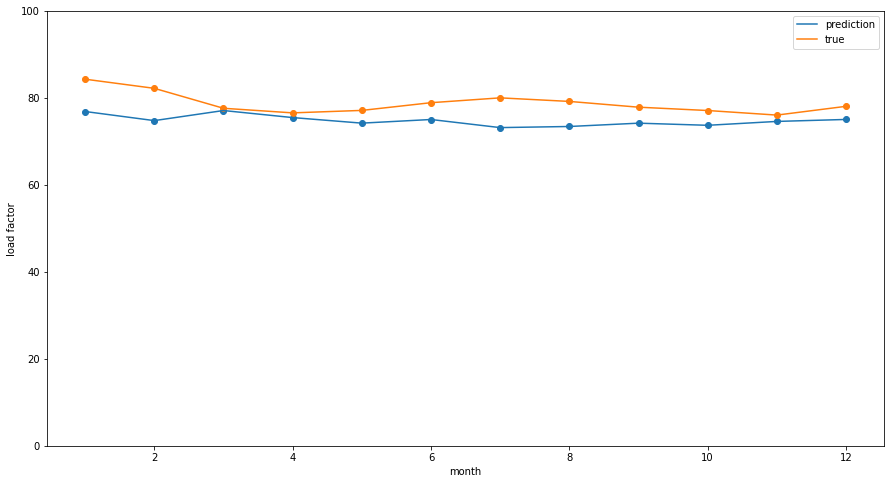

In [43]:
# select the company to get its load factor predictions for over the year 2022
company = 5  # there are 10 companies to test over so the valid range of values for this is 0-9

fig, axes = plt.subplots(figsize=(15, 8))

plt.plot(list(range(1, 13)), validation_predictions.iloc[company*12:company*12+12, 0], label='prediction')
plt.scatter(list(range(1, 13)), validation_predictions.iloc[company*12:company*12+12, 0])
plt.plot(list(range(1, 13)), validation_predictions.iloc[company*12:company*12+12, 1], label='true')
plt.scatter(list(range(1, 13)), validation_predictions.iloc[company*12:company*12+12, 1])

plt.xlabel('month')
plt.ylabel('load factor')
plt.legend()
plt.ylim([0, 100])
plt.show()

Interestingly, the best models are with fewer epochs. The tendency of RNN models to overfit to data has been documented before but we are surprised by the level to which the model is overfitting after training for such few epochs.

# Submission Code

In [ ]:
test_df = pd.read_csv('filtered_data/norm_submission_df.csv')
test_df = test_df.drop(['Unnamed: 0'], axis=1)
test_df

In [ ]:
# set the index to be this and don't drop
test_df.set_index(keys=['organization_code_iata'], drop=False,inplace=True)
# get a list of names
names = test_df['organization_code_iata'].unique().tolist()
test_df = [test_df.loc[test_df.organization_code_iata==name].sort_values(['year', 'month'], ascending=[True, True]) for name in names]

In [ ]:
# puts data in temporal order and sort by organization #
x_test = [test[["year", "month", "airline_type_0", "airline_type_1", "airline_type_2", "airline_type_3", "airline_type_4", "airline_type_5", "total_seats", "stringency_index"]].reset_index() for test in test_df]

In [ ]:
x_test[0]

In [ ]:
def make_tensor(x_data):
    # Create (N x L x H_in) data from (num_orgs x num_months x H_in)
    x_tensor = np.empty([0, L, H_in])

    position = 0
    # loop over every airline org
    for idx, (x) in enumerate(x_data):
        x = x.to_numpy()  
        x = x[:, 3:]
        
        for idx, (xs) in enumerate(x):
            if idx > x.shape[0] - L-1:
                continue
                
            x_tensor = np.concatenate([x_tensor, x[idx:idx+L].reshape(1, L, -1)], axis=0)
    
    x_tensor = torch.from_numpy(x_tensor.astype(float))
    
    return x_tensor

x_tensor = make_tensor(x_test)
x_tensor.shape

In [ ]:
class TestDataset(Dataset):
    def __init__(self, x_data):
        super().__init__()
        self.x = x_data
    
    def __len__(self):
        return self.x.shape[0]
        
    def __getitem__(self, idx):
        x = self.x[idx].type('torch.DoubleTensor')
        return x

test_data = TestDataset(x_tensor)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
x = next(iter(test_loader))
print(x.shape)

In [ ]:
with torch.no_grad():
    model = LSTM(input_size=H_in, hidden_size=50, output_size=H_out, unnorm_data=unnorm_data).cpu() 
    model.load_state_dict(torch.load(f"stringency_models/lstm-{best_MAPE_model['epoch']}.pt"))
    
    LoadFactorPredictions = []
    for idx, (x) in enumerate(test_loader):
        y_hat = model(x.float())
        y_hat = model.unnorm(y_hat)[:, 0]
        
        LoadFactorPredictions.append(y_hat.item())

In [ ]:
test_predictions = pd.DataFrame({'pred_load_factor': LoadFactorPredictions})
test_predictions

In [ ]:
test_predictions.to_csv('pred_load_factors.csv')